In [1]:
from validphys.api import API
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from gen_dicts import generate_dicts
from utils import XGRID
from model_utils import *

Using Keras backend


In [2]:
seed = 14132124
DEBUG = False
RUN_ANIMATION = True

In [3]:
# List of DIS dataset
dataset_inputs = [
  #{'dataset': 'NMC_NC_NOTFIXED_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'NMC_NC_NOTFIXED_P_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'SLAC_NC_NOTFIXED_P_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'SLAC_NC_NOTFIXED_D_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'BCDMS_NC_NOTFIXED_P_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'BCDMS_NC_NOTFIXED_D_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'CHORUS_CC_NOTFIXED_PB_DW_NU-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'CHORUS_CC_NOTFIXED_PB_DW_NB-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'NUTEV_CC_NOTFIXED_FE_DW_NU-SIGMARED', 'cfac': ['MAS'], 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'NUTEV_CC_NOTFIXED_FE_DW_NB-SIGMARED', 'cfac': ['MAS'], 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_225GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_251GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_300GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_CC_318GEV_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_CC_318GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EAVG_CHARM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EAVG_BOTTOM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
]

# Dictionary for validphys API
common_dict = dict(
    dataset_inputs=dataset_inputs,
    metadata_group="nnpdf31_process",
    use_cuts='internal',
    datacuts={'q2min': 3.49, 'w2min': 12.5},
    theoryid=40000000,
    t0pdfset='NNPDF40_nnlo_as_01180',
    use_t0=True
)

In [4]:
# Retrieve data from NNPDF
groups_data = API.procs_data(**common_dict)
tuple_of_dicts = generate_dicts(groups_data)
fk_table_dict = tuple_of_dicts.fk_tables
central_data_dict = tuple_of_dicts.central_data

In [5]:
C_sys = API.dataset_inputs_t0_covmat_from_systematics(**common_dict)
C = API.groups_covmat_no_table(**common_dict)

# Serialize covmat
C.to_pickle(path='./serialised_data/covmat.pkl')
C_index = C.index
C_col = C.columns
Cinv = np.linalg.inv(C)
Cinv = pd.DataFrame(Cinv, index=C_index, columns=C_col)

# Diagonalize covariance matric
eigvals_Cinv, R_Y = np.linalg.eigh(Cinv)
if eigvals_Cinv[-1] > eigvals_Cinv[0]:
    eigvals_Cinv = eigvals_Cinv[::-1]
    R_Y = R_Y[:,::-1]
D_Y = np.zeros_like(R_Y)
np.fill_diagonal(D_Y, eigvals_Cinv)

LHAPDF 6.5.4 loading /opt/homebrew/Caskroom/miniconda/base/envs/nnpdf/share/LHAPDF/NNPDF40_nnlo_as_01180/NNPDF40_nnlo_as_01180_0000.dat
NNPDF40_nnlo_as_01180 PDF set, member #0, version 1; LHAPDF ID = 331100


In [273]:
# Construct the big FK table matrix
ndata = 0
dataname_from_covmat = Cinv.index.get_level_values('dataset').unique()

vecs_for_stack = []
for i, (exp, fk) in enumerate(fk_table_dict.items()):
  ndata += fk.shape[0]
  if exp == dataname_from_covmat[i]:
    vecs_for_stack.append(fk.numpy().reshape((fk.shape[0], fk.shape[1] * fk.shape[2])))
  else:
    raise ValueError(f'Problem encountered {exp} != {dataname_from_covmat[i]}')

FK = np.vstack([fk.numpy().reshape((fk.shape[0], fk.shape[1] * fk.shape[2])) for fk in fk_table_dict.values()])
FK_plus = np.linalg.pinv(FK, rcond=1.e-3)
#FK = np.vstack(vecs_for_stack)

try:
  assert(FK.shape[0] == ndata)
except AssertionError:
  print('The number of points does not match.')

# Check that this FK is what we expect
try:
  test_matrix = np.random.rand(FK.shape[0], FK.shape[0])
  # Matrix product
  mat_prod = FK.T @ test_matrix

  # Tensor product
  shape = (*fk.shape[1:], *fk.shape[1:])
  result = np.zeros((fk.shape[1], fk.shape[2], FK.shape[0]))
  I = 0
  for fk in fk_table_dict.values():
    ndata = fk.shape[0]
    result += np.einsum('Iia, IJ -> iaJ',fk, test_matrix[I : I + ndata, :])
    I += ndata
  
  result_flatten = result.reshape((result.shape[0] * result.shape[1], result.shape[2]))
  assert(np.allclose(result_flatten, mat_prod))
  assert(np.allclose(result, mat_prod.reshape((result.shape[0], result.shape[1], result.shape[2]))))
except AssertionError:
  print('A problem occurred')

# Construct dataframe for predictions
Y = pd.DataFrame(np.zeros(Cinv.shape[0]), index=Cinv.index)
for exp_name, data in central_data_dict.items():
  if data.size == Y.loc[(slice(None), [exp_name], slice(None)), :].size:
    Y.loc[(slice(None), [exp_name], slice(None)), :] = data
  else:
    raise ValueError

In [290]:
# Generate the model and compute the NTK
nnpdf_model = generate_sequential_model(outputs=9, nlayers=2, units=[28, 20],seed=seed, name='NNPDF', kernel_initializer='RandomNormal', predictions=False, dtype='float32')
NTK = compute_ntk(nnpdf_model, XGRID, only_diagonal=False)

# Flatten NTK
prod = 1
oldshape = NTK.shape
for k in oldshape[2:]:
    prod *= k
NTK_flat = np.array(NTK).reshape(prod,-1)
eigvals_NTK, eigvecs_NTK = np.linalg.eigh(NTK_flat)
if eigvals_NTK[-1] > eigvals_NTK[0]:
  eigvals_NTK = eigvals_NTK[::-1]
  eigvecs_NTK = eigvecs_NTK[:,::-1]


# Compute predictions at initialization
f0 = nnpdf_model(XGRID).numpy()

# GD training

In [ ]:
X = tf.convert_to_tensor(XGRID)
X = tf.reshape(X, shape=(-1,1))

nnpdf_w_pred = generate_sequential_model(outputs=9, nlayers=2, units=[28, 20],seed=seed, name='NNPDF', kernel_initializer='RandomNormal', predictions=True, fk_table_dict=fk_table_dict, dtype='float32')
predictions = nnpdf_w_pred(X)

# Define optimizer
learning_rate_gd = 0.00000001

optimizer = tf.optimizers.SGD(learning_rate=learning_rate_gd)
results = train_network(model=nnpdf_w_pred, 
                                    show_log=True, 
                                    optimizer=optimizer, 
                                    input_model=X, 
                                    Cinv=Cinv, 
                                    data=central_data_dict,
                                    tol=1.e-16)

pred_in_time = results[1]
pdfs_in_time = results[2]
try:
  assert(np.allclose(pdfs_in_time[0].numpy(), f0))
except AssertionError:
  print('Something went wrong')

import pickle

with open('training.pkl', 'wb') as file:
  pickle.dump(results, file)


In [8]:
import pickle
with open('training.pkl', 'rb') as file:
    results = pickle.load(file)

pred_in_time = results[1]
pdfs_in_time = results[2]
learning_rate_gd = 0.00000001

The cell below computes the following matrices
$$
M = (FK)^T C_Y^{-1} (FK) = RDR^T\\[10pt]
\tilde{H} = D^{1/2} R^T \Theta_t R  D^{1/2}   \\[10pt]
\tilde{H}_{\epsilon} = D^{1/2}_Y R^T_Y (FK) \Theta (FK)^T R_Y D^{1/2}
$$

In [274]:
H_eps = np.sqrt(D_Y) @ R_Y.T @ FK @ NTK_flat @ FK.T @ R_Y @ np.sqrt(D_Y)
M = FK.T @ Cinv @ FK
b = NTK_flat @ FK.T @ Cinv @ Y

# Check that matrix H_eps is symmetric
try:
    assert(np.allclose(H_eps, H_eps.T, rtol = 5*1e-4, atol = 1e-8))
except AssertionError:
    print(f'Matrix H_eps is not symmetric due to numerical error...')
    H_eps = 0.5 * (H_eps + H_eps.T)

eigvals_H_eps, eigvecs_H_eps = np.linalg.eigh(H_eps)
if eigvals_H_eps[-1] > eigvals_H_eps[0]:
  eigvals_H_eps = eigvals_H_eps[::-1]
  eigvecs_H_eps = eigvecs_H_eps[:,::-1]

# Check that matrix M is symmetric
try:
    assert(np.allclose(M, M.T))
except AssertionError:
    print(f'Matrix M is not symmetric')
else:
    eigvals_M, R = np.linalg.eigh(M)
    if eigvals_M[-1] > eigvals_M[0]:
      eigvals_M = eigvals_M[::-1]
      R = R[:,::-1]

    # Round eigenvalues to zero
    for i in range(eigvals_M.size):
      eigvals_M[i] = round_float32(eigvals_M[i], eigvals_M[0], tol_magnitude=1.e-8)

    # Build diagonal matrix D
    D = np.diag(eigvals_M)

# Compute matrix H_tilde
H_tilde = np.sqrt(D) @ R.T @ NTK_flat @ R @ np.sqrt(D)

# Check that matrix H_tilde is symmetric
try:
    assert(np.allclose(H_tilde, H_tilde.T, rtol = 5*1e-4, atol = 1e-8))
except AssertionError:
    print(f'Matrix H_tilde is not symmetric')
    H_tilde = 0.5 * (H_tilde + H_tilde.T)

eigvals_H_tilde, eigvecs_H_tilde = np.linalg.eigh(H_tilde)
if eigvals_H_tilde[-1] > eigvals_H_tilde[0]:
  eigvals_H_tilde = eigvals_H_tilde[::-1]
  eigvecs_H_tilde = eigvecs_H_tilde[:,::-1]

Matrix H_eps is not symmetric due to numerical error...
Matrix H_tilde is not symmetric


Text(0.1, 0.6, '$M = (FK)^T C^{-1}_Y (FK)$')

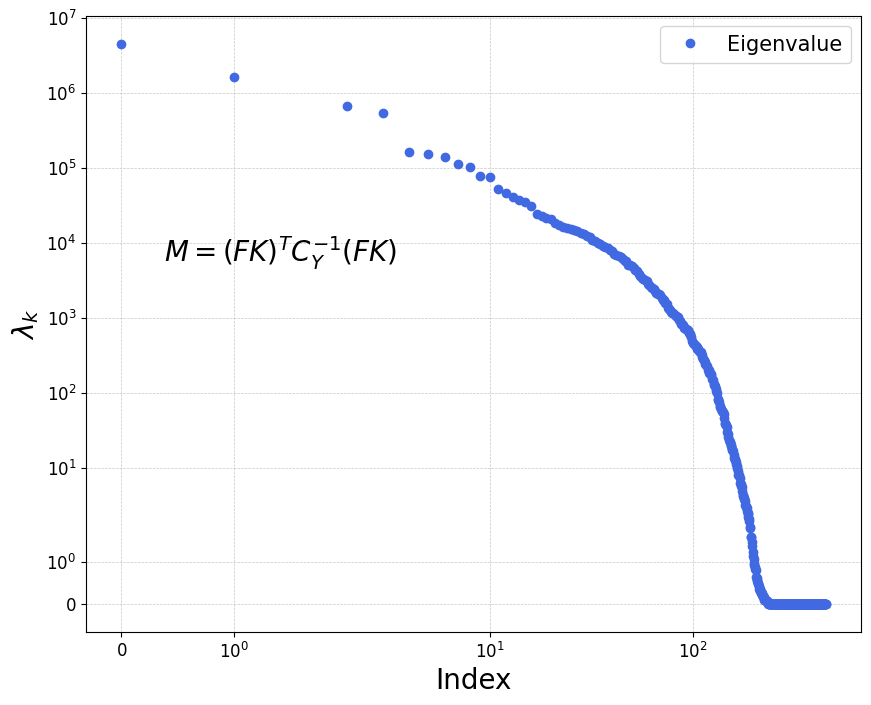

In [48]:
from plot_utils import plot_eigvals
fig, axs = plot_eigvals(eigvals_M, figsize=(10,8), title='')
axs.text(0.1, 0.60, r'$M = (FK)^T C^{-1}_Y (FK)$', fontsize=20, transform=axs.transAxes)

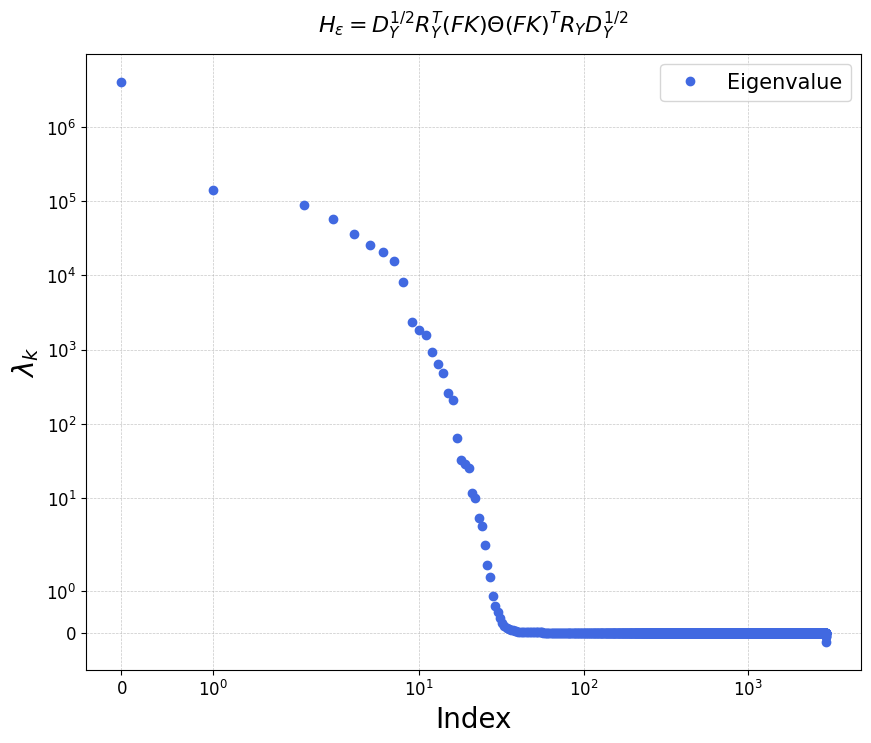

In [49]:
fig, axs = plot_eigvals(eigvals_H_eps, figsize=(10,8), title=r'$H_{\epsilon} = D^{1/2}_Y R^T_Y (FK) \Theta (FK)^T R_Y D^{1/2}_Y$')

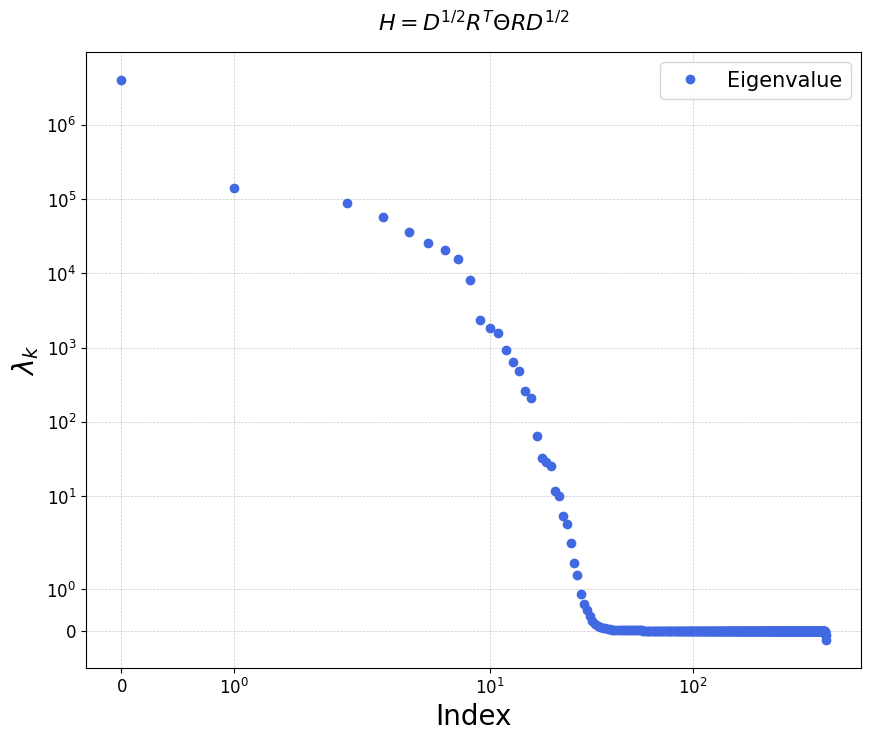

In [50]:
fig, axs = plot_eigvals(eigvals_H_tilde, figsize=(10,8), title=r'$H= D^{1/2} R^T \Theta R D^{1/2}$')

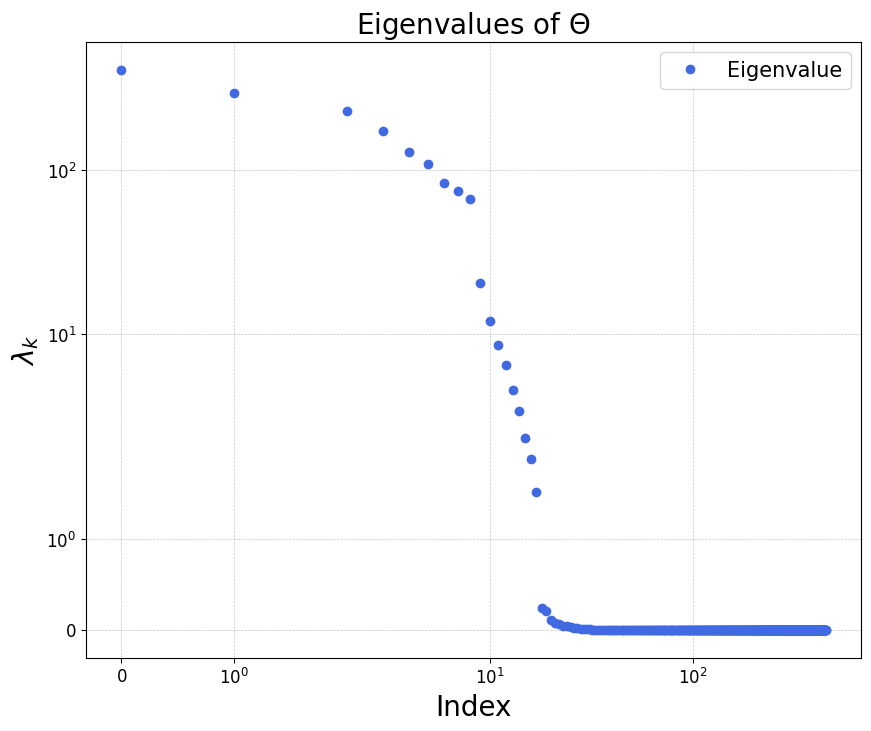

In [293]:
fig, axs = plot_eigvals(eigvals_NTK, figsize=(10,8), title='')
axs.set_title(r'Eigenvalues of $\Theta$', fontsize=20)
fig.savefig('/Users/s2569857/Codes/DeepLearningTheory/doc/figs/ntk_eigvals.pdf')

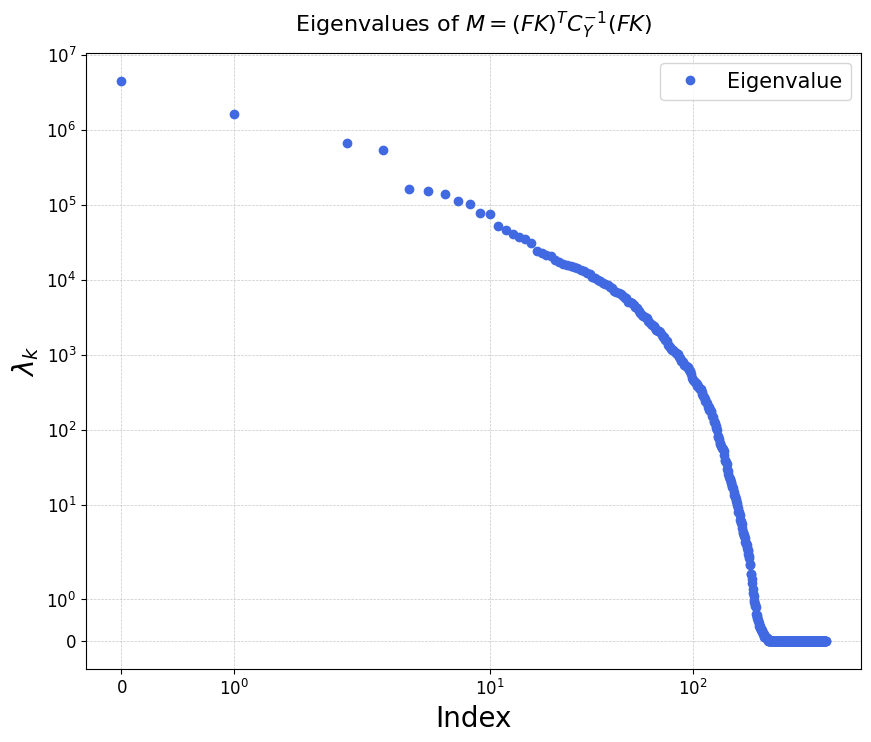

In [295]:
fig, axs = plot_eigvals(eigvals_M, figsize=(10,8), title=r'Eigenvalues of $M = (FK)^T C_Y^{-1} (FK)$')
#axs.set_title(r'Eigenvalues of $\Theta$', fontsize=20)
fig.savefig('/Users/s2569857/Codes/DeepLearningTheory/doc/figs/m_eigvals.pdf')

# Null-space of (FK)

In [279]:
import scipy as sp
def nullspace(matrix, orth_space=False, rcond=1.e-8):
  ker = sp.linalg.null_space(matrix, rcond=rcond)

  if orth_space:
    # Compute SVD of the null space
    _, _, Vh = np.linalg.svd(ker.T, full_matrices=True)
    orthogonal_space = Vh[len(ker.T):].T
    return ker, orthogonal_space
  
  else:
    return ker
  
def project_matrix(matrix, basis):
  basis_dim = basis.shape[1]
  space_dim = basis.shape[0]
  if space_dim != matrix.shape[1]:
    raise ValueError ('The matrix cannot be projected into the basis')
  
  M_orth = np.zeros((basis_dim, basis_dim))
  for i in range(basis_dim):
    for j in range(basis_dim):
      M_orth[i,j] = basis[:,i].T @ matrix @ basis[:,j]

  return M_orth

def project_vector(vector, basis):
  basis_dim = basis.shape[1]
  space_dim = basis.shape[0]
  if space_dim != vector.shape[0]:
    raise ValueError ('The matrix cannot be projected into the basis')
  
  res = [np.dot(vector, basis[:,i]) for i in range(basis_dim)]
  return res

The FK tables and the matrix M should share the same null space. However, when the two null spaces are computed separately, they are different...

In [289]:
# Computing the null space of the matrix M and its orthogonal space
m, n = FK.shape[0], FK.shape[1]
rcond_FK = 1.e-8
ker_M, ker_orth_M = nullspace(M, orth_space=True, rcond=rcond_FK)

u_FK, s_FK, vh_FK = np.linalg.svd(FK, full_matrices=True)
u_M, s_M, vh_M = np.linalg.svd(M, full_matrices=True)
tol_M = np.amax(s_M, initial=0.) * rcond_FK
tol_FK = np.amax(s_FK, initial=0.) * rcond_FK

# Regularise singular values
for i in range(s_M.size):
  if s_M[i] < tol_M:
    s_M[i] = 0.0
  if s_FK[i] < tol_FK:
    s_FK[i] = 0.0

# Reconstruct the FK tables after regularization
smat_M = np.zeros((u_M.shape[0], vh_M.shape[0]), dtype=np.float32)
smat_M[:vh_M.shape[0], :vh_M.shape[0]] = np.diag(s_M)
M_reg = u_M @ smat_M @ vh_M

smat_FK = np.zeros((u_FK.shape[0], vh_FK.shape[0]), dtype=np.float32)
smat_FK[:vh_FK.shape[0], :vh_FK.shape[0]] = np.diag(s_FK)
FK_reg = u_FK @ smat_FK @ vh_FK

#for i in range(ker_M.shape[1]):
#  print(f'{i} : {np.linalg.norm(M_reg @ ker_M[:,i])} | {np.linalg.norm(FK_reg @ ker_orth_M[:,i])}')

Project M into the space orthogonal to ker(M)

In [287]:
M_botbot = project_matrix(M_reg, ker_orth_M)
NTK_botbot = project_matrix(NTK_flat, ker_orth_M)
b_bot = project_vector(b.to_numpy()[:,0], ker_orth_M)

In [ ]:
# Compute H_tilde in the space orthogonal to ker(FK)
eigvals_H_botbot, R_botbot = np.linalg.eigh(M_botbot)
if eigvals_H_botbot[-1] > eigvals_H_botbot[0]:
  eigvals_H_botbot = eigvals_H_botbot[::-1]
  R_botbot = R_botbot[:,::-1]
D_botbot = np.diag(R_botbot)
H_botbot = np.sqrt(D_botbot) @ R_botbot.T @ NTK_botbot @ R_botbot @ np.sqrt(D_botbot)

# Evolution of the data

In [ ]:
from functools import lru_cache

# Construct dataframe for predictions
Y = pd.DataFrame(np.zeros(Cinv.shape[0]), index=Cinv.index)
for exp_name, data in central_data_dict.items():
  if data.size == Y.loc[(slice(None), [exp_name], slice(None)), :].size:
    Y.loc[(slice(None), [exp_name], slice(None)), :] = data
  else:
    raise ValueError
  
eps_0 = Y.to_numpy()[:,0] - FK @ f0.flatten()
Ly = (L @ Y).to_numpy()[:,0]
L_eps0 = L @ eps_0

L_eps0_tilde = [np.dot(L_eps0, eigvecs[:,k]) for k in range(eigvecs.shape[1])]
pre_computed_coefficients = [Linv @ eigvecs[:,k] * L_eps0_tilde[k] for k in range(eigvals_reg.size)] 

@lru_cache(maxsize=None)
def preds_t(t, learning_rate = 0.00001, eig_range=None):
  if eig_range is None:
    eig_range = eigvals_reg.size
  predictions = [pre_computed_coefficients[k] * np.exp(-eigvals_reg[k] * learning_rate* t) for k in range(eig_range)] 
  predictions = np.sum(predictions, axis=0)

  predictions = pd.DataFrame(predictions, index=Y.index)
  predictions = Y - predictions
  return predictions

In [ ]:
experiments = ['NMC_NC_NOTFIXED_P_EM-SIGMARED', 'SLAC_NC_NOTFIXED_P_EM-F2', 'BCDMS_NC_NOTFIXED_D_EM-F2', 'HERA_NC_318GEV_EM-SIGMARED']
exp_titles = ['NMC', 'SLAC NC P', 'BCDMS NC D', 'HERA NC 318GEV']
y_labels = [r'$\sigma$', r'$F_2$', r'$F_2$', r'$\sigma$']
t = 0.
fig_pred, axes_pred = plt.subplots(2, 2, figsize=(25, 25))  # Adjust figsize for desired plot size
preds = preds_t(t, learning_rate=learning_rate_gd)

scat_gf = []
scat_gd = []
text = []
for i, ax in enumerate(axes_pred.flat):
    y = Y.xs(level='dataset', key=experiments[i]).to_numpy()
    p = preds.xs(level='dataset', key=experiments[i]).to_numpy()
    trained_pred = pred_in_time[0][experiments[i]]
    ax.scatter(np.arange(y.size), y, color='green', label='Central data', marker='o', s=100, alpha=0.4)
    gf = ax.scatter(np.arange(y.size), p, color='orange', label='Analytical solution', marker='^', s=100)
    gd = ax.scatter(np.arange(y.size), trained_pred, color='red', label='Gradient descent', marker='v', s=100)
    scat_gf.append(gf)
    scat_gd.append(gd)
    #ax.set_xlabel(r'$x$')
    ax.set_ylabel(y_labels[i], fontsize=20)
    #ax.set_xscale('log')
    ax.set_title(exp_titles[i], x=0.8,fontsize=20, fontweight='bold')
    ax.legend(fontsize=20)
    text_t = ax.text(0.05, 1.01, f't = {t}, learning rate = {learning_rate_gd}', fontsize=20, transform=ax.transAxes)
    text.append(text_t)


plt.tight_layout()
#fig.savefig('data_evolution.pdf')

In [ ]:
experiments = ['NMC_NC_NOTFIXED_P_EM-SIGMARED', 'SLAC_NC_NOTFIXED_P_EM-F2', 'BCDMS_NC_NOTFIXED_D_EM-F2', 'HERA_NC_318GEV_EM-SIGMARED']
exp_titles = ['NMC', 'SLAC NC P', 'BCDMS NC D', 'HERA NC 318GEV']
y_labels = [r'$\sigma$', r'$F_2$', r'$F_2$', r'$\sigma$']
t = 0.
fig_eps, axes_eps = plt.subplots(2, 2, figsize=(25, 25))  # Adjust figsize for desired plot size
preds = preds_t(t, learning_rate=learning_rate_gd)

scat_gf_eps = []
scat_gd_eps = []
text_eps = []
for i, ax in enumerate(axes_eps.flat):
    y = Y.xs(level='dataset', key=experiments[i]).to_numpy()
    p = y - preds.xs(level='dataset', key=experiments[i]).to_numpy()
    trained_pred = y[:,0] - pred_in_time[int(t)][experiments[i]].numpy()
    ax.scatter(np.arange(y.size), y, color='green', label='Central data', marker='o', s=100, alpha=0.4)
    gf = ax.scatter(np.arange(y.size), p, color='orange', label='Analytical solution', marker='^', s=100)
    gd = ax.scatter(np.arange(y.size), trained_pred, color='red', label='Gradient descent', marker='v', s=100)
    scat_gf_eps.append(gf)
    scat_gd_eps.append(gd)
    #ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$\epsilon$', fontsize=20)
    #ax.set_xscale('log')
    ax.set_title(exp_titles[i], x=0.8,fontsize=20, fontweight='bold')
    ax.legend(fontsize=20)
    text_t = ax.text(0.05, 1.01, f't = {t}, learning rate = {learning_rate_gd}', fontsize=20, transform=ax.transAxes)
    text_eps.append(text_t)


plt.tight_layout()
#fig.savefig('data_evolution.pdf')

In [ ]:
def compute_loss_analytical(t, eig_range=None):
  preds = preds_t(t, learning_rate=learning_rate_gd, eig_range=eig_range)
  loss = 0
  ndata = 0
  for exp in Y.index.get_level_values('dataset').unique():
    y = Y.xs(level='dataset', key=exp).to_numpy()
    Cinv_exp = Cinv.xs(level="dataset", key=exp).T.xs(level="dataset", key=exp).to_numpy()
    p = preds.xs(level='dataset', key=exp).to_numpy()
    R = y[:,0] - p[:,0]
    loss += 0.5 * R.T @ Cinv_exp @ R
    ndata += Cinv_exp.shape[0]
  return float(loss) / ndata

def compute_loss_gd(t):
  preds = pred_in_time[int(t)]
  loss = 0
  ndata = 0
  for exp, pred in preds.items():
    y = Y.xs(level='dataset', key=exp).to_numpy()
    Cinv_exp = tf.convert_to_tensor(Cinv.xs(level="dataset", key=exp).T.xs(level="dataset", key=exp).to_numpy(), name=f'Cinv_{exp}', dtype='float32')
    R = tf.convert_to_tensor(y[:,0] - pred, name=f'residue_{exp}', dtype='float32')
    Cinv_R = tf.linalg.matvec(Cinv_exp, R)
    loss += 0.5 * tf.reduce_sum(tf.multiply(R, Cinv_R))
    ndata += Cinv_exp.shape[0]
  return float(loss) / ndata


In [ ]:
time_steps_high = np.arange(1000,len(pred_in_time),1000)
time_steps_low = np.arange(0,1000,2)
time_steps = np.concatenate([time_steps_low, time_steps_high])
aloss = [compute_loss_analytical(t, eig_range=100) for t in time_steps]
gd_loss = [compute_loss_gd(t) for t in time_steps]

In [ ]:
fig_loss, ax_loss = plt.subplots(figsize=(10, 7))  # Adjust figsize for desired plot size

ax_loss.scatter(time_steps, aloss, label='Analytical solution')
ax_loss.scatter(time_steps, gd_loss, label='Gradient descent')
ax_loss.set_xlabel(r'$t$')
ax_loss.set_ylabel(r'Loss function', fontsize=20)
ax_loss.set_xscale('symlog')
ax_loss.set_title('MSE in function of training time', x=0.5, fontsize=20, fontweight='bold')
ax_loss.legend(fontsize=20)
#text_t = ax.text(0.05, 1.01, f't = {t}, learning rate = {learning_rate_gd}', fontsize=20, transform=ax.transAxes)
#text.append(text_t)


plt.tight_layout()
fig_loss.savefig('Loss_function_time.pdf')

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Animation function
# Update function for predicitons
def update_preds(t):
    preds = preds_t(t, learning_rate=learning_rate_gd)
    for i, (gf, gd, text_t) in enumerate(zip(scat_gf, scat_gd, text)):
        # Update the y-data for each subplot's line
        y = Y.xs(level='dataset', key=experiments[i]).to_numpy()
        p = preds.xs(level='dataset', key=experiments[i]).to_numpy()
        trained_pred = pred_in_time[int(t)][experiments[i]]
        data_gf = np.hstack(( np.arange(y.size)[:, np.newaxis] , p))
        data_gd = np.hstack(( np.arange(y.size)[:, np.newaxis] , trained_pred[:,np.newaxis]))
        gf.set_offsets(data_gf)  # Example: Add phase shift based on t and subplot index
        gd.set_offsets(data_gd)  # Example: Add phase shift based on t and subplot index
        text_t.set_text(f't = {t}, learning rate = {learning_rate_gd}')
    return scat_gf + scat_gd + text

# Update function for epsilon
def update_eps(t):
    preds = preds_t(t, learning_rate=learning_rate_gd)
    for i, (gf, gd, text_t) in enumerate(zip(scat_gf_eps, scat_gd_eps, text_eps)):
        # Update the y-data for each subplot's line
        y = Y.xs(level='dataset', key=experiments[i]).to_numpy()
        p = preds.xs(level='dataset', key=experiments[i]).to_numpy()
        trained_pred = pred_in_time[int(t)][experiments[i]]
        data_gf = np.hstack(( np.arange(y.size)[:, np.newaxis] , p))
        data_gd = np.hstack(( np.arange(y.size)[:, np.newaxis] , trained_pred[:,np.newaxis]))
        gf.set_offsets(data_gf)  # Example: Add phase shift based on t and subplot index
        gd.set_offsets(data_gd)  # Example: Add phase shift based on t and subplot index
        text_t.set_text(f't = {t}, learning rate = {learning_rate_gd}')
    return scat_gf + scat_gd + text

In [ ]:
ani_pred = FuncAnimation(fig_pred, update_preds, frames=np.arange(0, len(pred_in_time), 1000), interval=10, blit=True, cache_frame_data=False)
ani_eps = FuncAnimation(fig_eps, update_eps, frames=np.arange(0, len(pred_in_time), 1000), interval=10, blit=True, cache_frame_data=False)

# Save the animation in the background
ani_pred.save('prediction_evolution.mp4', writer='ffmpeg', fps=20)
ani_eps.save('epsilon_evolution.mp4', writer='ffmpeg', fps=20)